# Storm surge modelling for tropical cyclones

### TCSurgeBathtub class: information

- TC Surge Geo Claw: https://climada-petals.readthedocs.io/en/stable/tutorial/climada_hazard_TCSurgeGeoClaw.html
- TC Surge Bathtub: https://climada-petals.readthedocs.io/en/stable/tutorial/climada_hazard_TCSurgeBathtub.html

Contains surges generated by tropical cyclones. Given a TropCyclone instance, it computes the surges for each historical and/or synthetic event at every centroid. TCSurgeBathtub inherits from Hazard and has an associated hazard type TCSurgeBathtub. 

Link to wind-surge relationship: https://ams.confex.com/ams/pdfpapers/168806.pdf (download)

- First the surge height is computed from the TC's gust field following an approximation to the SLOSH model (wind-surge relationship in Xu (2010): linear function: s1 = a * (v1 - v0) + s0
- elevation of centroids is substracted to the surge using a DEM of 30m or 90m resolution (SRTM1, SRTM3, using the python elevation package)
- A decay of surge hieght is implemented over flat land (up to 10 m elevation) until 50km inland with a decay factor of 0.2 meters per kilometer. 

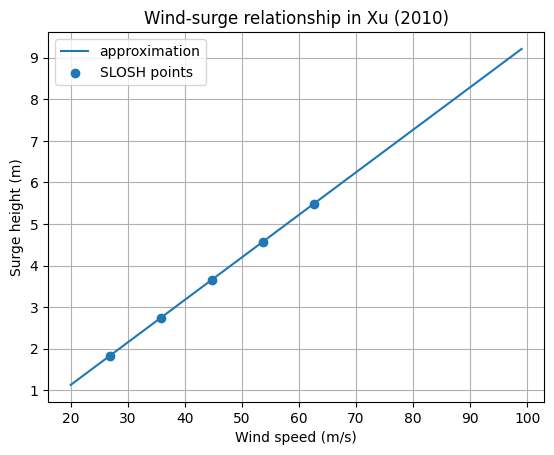

In [4]:
from TC_hazard_modelling import plot_windsurgerelation_Xu

plot_windsurgerelation_Xu()

### For the historical tropical cyclone database IBTrACS

- Link: https://www.ncei.noaa.gov/products/international-best-track-archive

Only the TC tracks from 1940 to 2024 are used in this notebook for consistency in the overall project. This can be easily modified. 

### Overview

This notebook follows the steps below: 
1. Preparations: loading packages and setting a standard for fonts/colour use
2. Generate centroids: create the points for which the modelling will take place
3. Load tracks: loading the TC tracks to be used
4. Model the hazard: modelling storm surge for all selected tracks, output to be saved
5. EXTRA CODE: Running 10 X 1,000 years of data in one cell

# 1. Preparations

### 1a. Load packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import time
import os
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
import climada
from climada.hazard import TCTracks
from climada.hazard import TropCyclone, Centroids
from climada.util.constants import SYSTEM_DIR
from climada_petals.hazard import TCSurgeBathtub

### 1b. Import functions out python file

In [7]:
import importlib
import TC_hazard_modelling

importlib.reload(TC_hazard_modelling)

# 2. Generate centroids
from TC_hazard_modelling import create_centroids_from_shapefiles
from TC_hazard_modelling import plot_all_grids_with_zoom

# 3. Load tracks
from TC_hazard_modelling import select_tracks
from TC_hazard_modelling import extract_selected_tracks

#4. Model the hazard
from TC_hazard_modelling import compute_surge

In [8]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### 1c. Create color palette and choose font

In [10]:
my_colors = {
    "510brown": "#c6bc8b",
    "510darkblue": "#00214d",
    "510lightblue": "#d4e6ff",
    "510red": "#dd281f",
    "510lightred": "#ff7876", 
    "510purple": "#958dbe"
}

plt.rcParams["font.family"] = "Arial"

# 2. Generate centroids: a grid of points from the country shapefiles

### 2a. Create a list of centroids per country

In [20]:
centroids_list, shapefiles_list = create_centroids_from_shapefiles(folder_path = "0-level-Leeward++",      # Path to folder of shapefile(s) 
                                                                   resolution_km = 0.5,                      # Desired resolution for point grid (km)
                                                                   buffer_km = 1)                          # Optional buffer around the borders of a shapefile (km)

Created centroids for 14 shapefiles.


# 3. Load IBTrACS data

### 3a. Use TCTracks to import tracks from IBTrACS

In [23]:
tracks = TCTracks.from_ibtracs_netcdf(provider = 'usa', basin="NA", year_range = (1940, 2024), interpolate_missing = True)
print("Number of tracks:", tracks.size)

2025-10-08 14:48:48,611 - climada.hazard.tc_tracks - WARNING - 280 storm events are discarded because no valid wind/pressure values have been found: 1940141N22289, 1940252N15313, 1940299N22288, 1941267N14300, 1942215N16275, ...
2025-10-08 14:48:48,622 - climada.hazard.tc_tracks - WARNING - 50 storm events are discarded because only one valid timestep has been found: 1940240N26295, 1940263N12279, 1940266N29311, 1940294N12281, 1942283N30289, ...
Number of tracks: 989


### 3b. Pre-select tracks passing the study area

In [25]:
tracks_LeewardIslands = select_tracks(tracks = tracks,                          # Output of step 3a
                                      lon_min = -69, lon_max = -58,             # -69 to -58 degrees West,
                                      lat_min = 12, lat_max = 21)               # 12 to 21 degrees North

print("Number of tracks:", tracks_LeewardIslands.size)

Number of tracks: 209


### 3c. Create a list of the storm IDs of the selected tracks and load tracks again

In [27]:
tr_ = extract_selected_tracks(tracks = tracks_LeewardIslands)

Number of tracks: 209


# 4. Model the hazard

### 4a. Generate wind fields per track and model corresponding storm surge, for all storms per point in CSV files
_Runs in +/- 2 minutes_

The function loops through all storms:
1. Creates a new TropCyclone object, including the wind field of that track (tc)
2. Calculates the surge (in meters) using TCSurgeBathtub.from_tc_winds, and using the elevation file (tc_surge)
3. Extracts the surge intensity directly from the results and takes the maximum over the duration of the storm, per point (surge_value)
4. Saves the data to a CSV file: SID, ISO, lon, lat, surge_m

In [30]:
start_time = time.time()

# Additional data required: 
# Path to a digital elevation model, including both land and ocean bathymetry: use the highest resolution available
elev_file = "SRTM15Plus/output_SRTM15Plus_-69_-58_12_21_filled.tif"

df = compute_surge(tc_tracks_dict = tr_,                                                     # Output of step 3c
                   centroids_list = centroids_list,                                          # Output of step 2a
                   shapefiles = shapefiles_list,                                             # Output of step 2a
                   elev_file = elev_file,
                   output_csv_path = "surge_output/IBTrACS_surge_0.5kmgrid_Leeward++.csv")

print(f'Running time: {(time.time() - start_time):.2f} seconds')

Combined surge results saved to surge_output/IBTrACS_surge_0.5kmgrid_Leeward++.csv
Running time: 508.49 seconds


### 4b. Apply peak over threshold to only keep storms that lead to extreme values OR only keep points of extreme values

In [41]:
df = pd.read_csv("surge_output/IBTrACS_surge_0.5kmgrid_Leeward++.csv")

# Keep only storms that have at least surge levels a *at least one* point ≥ 0.2 m
sids_to_keep = df[df['surge_m'] >= 0.2]['SID'].unique()
df_filtered = df[df['SID'].isin(sids_to_keep)]

df_filtered.to_csv("surge_output/IBTrACS_surge_0.5kmgrid_Leeward++_POT.csv")

In [15]:
df = pd.read_csv("surge_output/IBTrACS_surge_0.5kmgrid_Leeward++.csv")

# Keep only points that have at least surge levels ≥ 0.2 m
df_filtered = df[df["surge_m"] >= 0.2] 

df_filtered.to_csv("surge_output/IBTrACS_surge_0.5kmgrid_Leeward++_POT2.csv")

### 4c. Optional: check output for Irma (2017)

In [43]:
print(f"Size of output: {df.shape}")
print(df[df['surge_m'] == 0].count())

df_Irma = df[df['SID'] == '2017242N16333']
grouped = df_Irma.groupby('ISO', as_index=False)['surge_m'].max()
grouped = grouped.rename(columns={'surge_m': 'max_surge_m'})

Size of output: (15068273, 5)
SID        15057887
ISO        15057887
lon        15057887
lat        15057887
surge_m    15057887
dtype: int64


### 4d. Optional: check output for extreme values

In [52]:
df = pd.read_csv("surge_output/IBTrACS_surge_0.5kmgrid_Leeward++.csv")
df_filtered = pd.read_csv("surge_output/IBTrACS_surge_0.5kmgrid_Leeward++_POT.csv")
print(f"Size of output: {df_filtered.size}")

print(f"\nOriginal number of storms (unique SIDs): {df['SID'].nunique():,}")
print(f"Filtered number of storms (unique SIDs): {df_filtered['SID'].nunique():,}")
print(f"Storms removed: {df['SID'].nunique() - df_filtered['SID'].nunique():,}")


# Compute the maximum wind speed per storm
storm_max = df_filtered.groupby('SID')['surge_m'].max().reset_index()
storm_max.rename(columns={'surge_m': 'storm_max_surge_m'}, inplace=True)

print("\nMaximum surge level per storm (summary):")
print(storm_max['storm_max_surge_m'].describe())

print("\nTop 5 storms by maximum surge levels:")
print(storm_max.sort_values('storm_max_surge_m', ascending=False).head())

Size of output: 22494264

Original number of storms (unique SIDs): 209
Filtered number of storms (unique SIDs): 52
Storms removed: 157

Maximum surge level per storm (summary):
count    52.000000
mean      2.390065
std       1.167529
min       0.925762
25%       1.715069
50%       1.779730
75%       2.780784
max       6.087110
Name: storm_max_surge_m, dtype: float64

Top 5 storms by maximum surge levels:
              SID  storm_max_surge_m
46  2017260N12310           6.087110
44  2017242N16333           5.964187
22  1989254N13340           4.570449
16  1979238N12324           4.560669
25  1995241N11333           4.338396
